In [1]:
import numpy as np
from skimage.color import rgb2gray
from skimage.io    import imread as skread
import cv2, itk

import matplotlib.pyplot as plt
%matplotlib inline

146


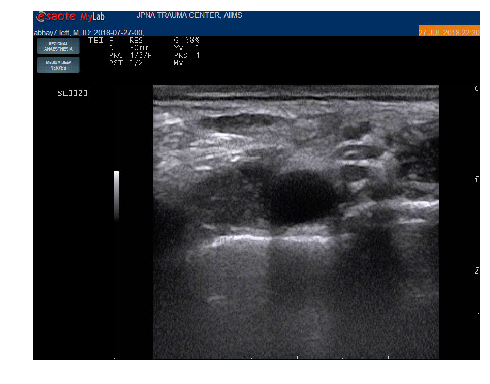

In [5]:
im = skread('frame313.tif')

# Find starting column of ultrasound image
arr = im[100:,600]
j = 100
for a in arr:
  j += 1
  if not(np.array_equal(a , im[600,0] )):
    print (j)
    break
    
plt.figure(figsize=(8,8))    
plt.imshow(im)
plt.axis('off')
plt.show()

(543, 562)


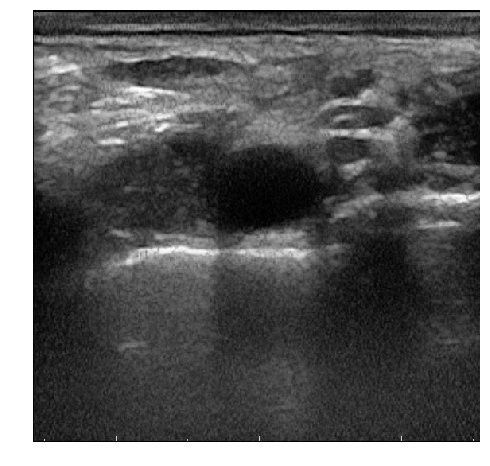

In [6]:
us_im = im[j-1:,236:798]
us_im = rgb2gray(us_im)
print (us_im.shape)

plt.figure(figsize=(8,8))
plt.imshow(us_im, cmap='gray')
plt.axis('off')
plt.show()

In [7]:
# https://www.kaggle.com/kmader/anisotropic-diffusion-example#
import scipy.ndimage.filters as flt
import warnings

def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
	"""
	Anisotropic diffusion.

	Usage:
	imgout = anisodiff(im, niter, kappa, gamma, option)

	Arguments:
	        img    - input image
	        niter  - number of iterations
	        kappa  - conduction coefficient 20-100 ?
	        gamma  - max value of .25 for stability
	        step   - tuple, the distance between adjacent pixels in (y,x)
	        option - 1 Perona Malik diffusion equation No 1
	                 2 Perona Malik diffusion equation No 2
	        ploton - if True, the image will be plotted on every iteration

	Returns:
	        imgout   - diffused image.

	kappa controls conduction as a function of gradient.  If kappa is low
	small intensity gradients are able to block conduction and hence diffusion
	across step edges.  A large value reduces the influence of intensity
	gradients on conduction.

	gamma controls speed of diffusion (you usually want it at a maximum of
	0.25)

	step is used to scale the gradients in case the spacing between adjacent
	pixels differs in the x and y axes

	Diffusion equation 1 favours high contrast edges over low contrast ones.
	Diffusion equation 2 favours wide regions over smaller ones.
  """
  
	# ...you could always diffuse each color channel independently if you
	# really want
	if img.ndim == 3:
		warnings.warn("Only grayscale images allowed, converting to 2D matrix")
		img = img.mean(2)

	# initialize output array
	img = img.astype('float32')
	imgout = img.copy()

	# initialize some internal variables
	deltaS = np.zeros_like(imgout)
	deltaE = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	gS = np.ones_like(imgout)
	gE = gS.copy()

	# create the plot figure, if requested
	if ploton:
		import pylab as pl
		from time import sleep

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(img,interpolation='nearest')
		ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
		ax1.set_title("Original image")
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in np.arange(1,niter):

		# calculate the diffs
		deltaS[:-1,: ] = np.diff(imgout,axis=0)
		deltaE[: ,:-1] = np.diff(imgout,axis=1)

		if 0<sigma:
			deltaSf=flt.gaussian_filter(deltaS,sigma);
			deltaEf=flt.gaussian_filter(deltaE,sigma);
		else: 
			deltaSf=deltaS;
			deltaEf=deltaE;
			
		# conduction gradients (only need to compute one per dim!)
		if option == 1:
			gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
			gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
		elif option == 2:
			gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
			gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

		# update matrices
		E = gE*deltaE
		S = gS*deltaS

		# subtract a copy that has been shifted 'North/West' by one
		# pixel. don't as questions. just do it. trust me.
		NS[:] = S
		EW[:] = E
		NS[1:,:] -= S[:-1,:]
		EW[:,1:] -= E[:,:-1]

		# update the image
		imgout += gamma*(NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(imgout)
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return imgout

In [8]:
fimg = anisodiff(us_im,100,80,0.075,(1,1),2.5,1)
#anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False)

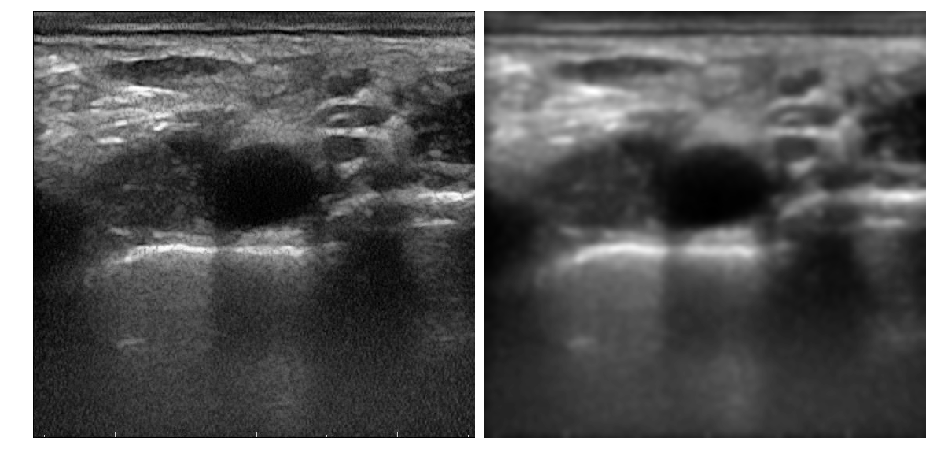

In [9]:
fig, axes = plt.subplots(1,2, figsize=(16, 8))
ax = axes.ravel()
ax[0].imshow(us_im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(fimg, cmap=plt.cm.gray)
ax[1].axis('off')
plt.subplots_adjust(wspace=0.02, hspace=0) 
plt.show()

In [10]:
from cv2.ximgproc import anisotropicDiffusion
'''
anisotropicDiffusion(src, alpha, K, niters[, dst]) -> dst
The function applies Perona-Malik anisotropic diffusion to an image. 
src = Grayscale Source image.
dst = Destination image of the same size and the same number of channels as src .
alpha = The amount of time to step forward by on each iteration (normally, it's between 0 and 1).
K = sensitivity to the edges
niters = The number of iterations
'''

In [17]:
ad_img = anisotropicDiffusion(us_im,0.075 ,80, 100)